In [2]:
# from nltk.classify import NaiveBayesClassifier
# from nltk.corpus import subjectivity
# from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

#import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt

from datetime import datetime
import matplotlib.dates as mdates
import importlib
import plotly.express as px
import base64

#from src.utils.keywords import get_event_metadata
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import io
from PIL import Image

from src.utils.analysis_tools import *


from src.utils import keywords
from src.utils import analysis_tools
from src.scripts import filters

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leoga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
path_final_yt_metadata = 'data/matching_videos.csv'
meta_data_df = pl.read_csv(path_final_yt_metadata, separator="\t")
path_final_time = 'data/df_timeseries_en.tsv'
time_df = pl.read_csv(path_final_time, separator="\t")
path_channel = 'data/df_channels_en.tsv'
channel_df = pl.read_csv(path_channel, separator="\t")

meta_data_df.head(1)
time_df.head(1)
channel_df.head(1)


ComputeError: could not parse `""Really they have to move the merchandise, so the closer you get to the actual date of Halloween, they'll be giving it away,"" consumer expert Janice Lieberman said. ""If you check Walmart and Amazon, you can get costumes for as a low as $8.` as dtype `str` at column 'categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count' (column number 1)

The current offset in the file is 9099 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `schema_overrides` argument
- setting `ignore_errors` to `True`,
- adding `""Really they have to move the merchandise, so the closer you get to the actual date of Halloween, they'll be giving it away,"" consumer expert Janice Lieberman said. ""If you check Walmart and Amazon, you can get costumes for as a low as $8.` to the `null_values` list.

Original error: ```invalid csv file

Field `""Really they have to move the merchandise, so the closer you get to the actual date of Halloween, they'll be giving it away,"" consumer expert Janice Lieberman said. ""If you check Walmart and Amazon, you can get costumes for as a low as $8.` is not properly escaped.```

In [5]:
def vader_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score


In [56]:
meta_data_df["sentiment"] = meta_data_df["title"].apply(vader_sentiment)
meta_data_df.to_csv('matching_videos_sentimet.csv')
meta_data_df.head(1)

categories                channel_id                  crawl_date  \
0  People & Blogs  UCzF4Ryn8TKn64md77gS5Q5Q  2019-11-04 21:11:23.560250   

                                         description dislike_count  \
0  There has been a lot of emotional reaction to ...           0.0   

    display_id duration like_count           tags  \
0  BFlU3b68aNs       60        3.0  politics,news   

                                               title          upload_date  \
0  Online reaction swift after Georgia House pass...  2019-03-29 00:00:00   

   view_count  sentiment  
0       401.0     0.2023

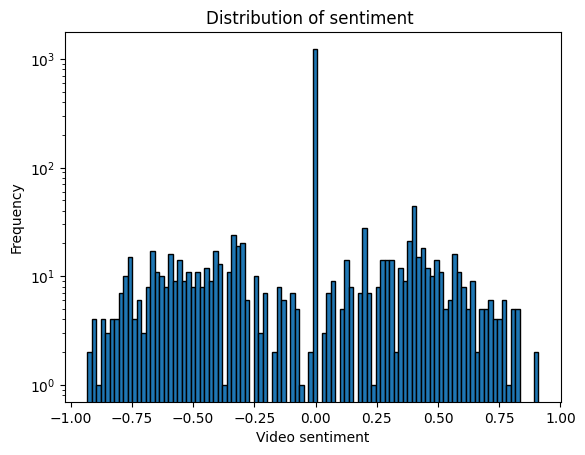

In [9]:
plt.hist(meta_data_df["sentiment"], bins= 100, edgecolor='black')
plt.xlabel('Video sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of sentiment ')
plt.yscale('log')
plt.show()

In [11]:
news_time_df = time_df[time_df['category'] == "News & Politics"]
news_time_df.head(1)


In [13]:
news_time_df['datetime'] = pd.to_datetime(news_time_df['datetime'])
news_time_df['year_month'] = news_time_df['datetime'].dt.to_period('M')
monthly_views = news_time_df.groupby('year_month')['delta_views'].sum()
print(monthly_views.head(1))

year_month
2015-10    133166.103627
Freq: M, Name: delta_views, dtype: float64


C:\Users\leoga\AppData\Local\Temp\ipykernel_35140\3894126653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_time_df['datetime'] = pd.to_datetime(news_time_df['datetime'])
C:\Users\leoga\AppData\Local\Temp\ipykernel_35140\3894126653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_time_df['year_month'] = news_time_df['datetime'].dt.to_period('M')


Text(0, 0.5, 'delta Views')

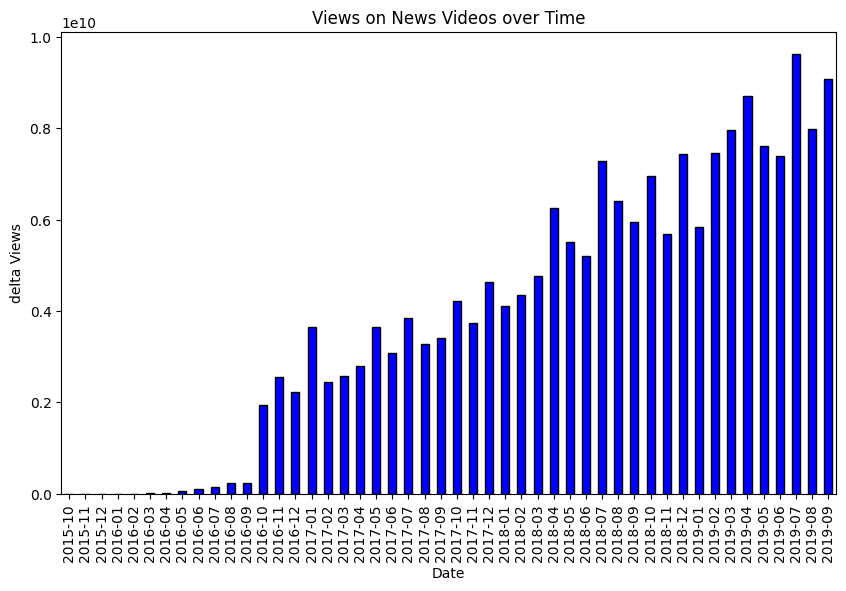

In [14]:
plt.figure(figsize=(12, 6))  # Set the figure size
# plt.plot(monthly_views.index, monthly_views.values, linestyle='-', color='b')
monthly_views.plot(kind='bar', figsize=(10, 6), color='b', edgecolor='black')
# Customize the plot
plt.title('Views on News Videos over Time')
plt.xlabel('Date')
plt.ylabel('delta Views')


category_cc   join_date                   channel    name_cc  \
0      Gaming  2010-04-29  UC-lHJZR3Gqxm24_Vd_AJ5Yw  PewDiePie   

   subscribers_cc  videos_cc  subscriber_rank_sb  weights  
0       101000000       3956                 3.0    2.087

In [16]:
fig = px.pie(channel_df, values='videos_cc', names='category_cc', title='YouTube videos by category')
fig.show()
#fig.write_html("videos_by_cat.html")

In [17]:
def plot_word_cloud(video_text, name):
    video_text= str.split(video_text.to_string(index=False))
    video_text= pd.Series(video_text)
        #filtering
    stop_words = set(STOPWORDS)
    filtered = [token for token in video_text if token.lower() not in stop_words]
    filtered = pd.Series(filtered)
    filtered = filtered.str.replace('.','')
    filtered = filtered.str.lower() #remove duplicates with different capitalisation
    filtered = filtered[filtered.str.len() > 1] #remove prepostion
    comment_words = ''
    
    # iterate through the csv file
    for val in filtered:
        
        # typecaste each val to string
        val = str(val)
        if(str.isascii(val)):
            # split the value
            tokens = val.split()
            comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 500,
                    background_color ='white',
                    stopwords = stop_words,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image       
                    
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('img/wordclouds/' + name, format='png', bbox_inches='tight')
    plt.close()



In [18]:
# all
plot_word_cloud(meta_data_df["title"].sample(10), "fig00")  #all    
plot_word_cloud(meta_data_df["title"].sample(10), "fig01")  #US
plot_word_cloud(meta_data_df["title"].sample(10), "fig02")  #Asia   
plot_word_cloud(meta_data_df["title"].sample(10), "fig03")  #Europa
# natural
plot_word_cloud(meta_data_df["title"].sample(10), "fig10")
plot_word_cloud(meta_data_df["title"].sample(10), "fig11")
plot_word_cloud(meta_data_df["title"].sample(10), "fig12")
plot_word_cloud(meta_data_df["title"].sample(10), "fig13")
# geoplitical
plot_word_cloud(meta_data_df["title"].sample(10), "fig20")
plot_word_cloud(meta_data_df["title"].sample(10), "fig21")
plot_word_cloud(meta_data_df["title"].sample(10), "fig22")
plot_word_cloud(meta_data_df["title"].sample(10), "fig23")

In [19]:

    #bakes the images into the html
def encode_image(filename):
    with open(filename, "rb") as img_file:
        return "data:image/png;base64," + base64.b64encode(img_file.read()).decode()

def interactive_cloud():
    
    fig = go.Figure()

    #definitions
    images = [
        [encode_image(f"img/wordclouds/fig{i}{j}") for j in range(4)] for i in range(3)
    ]

    image_dict = {
        'sizex': 8,
        'sizey': 5,
        'x': -1,
        'y': 4,
        'xref': 'x',
        'yref': 'y',
        'opacity': 1.0,
        'layer': 'below',
    }

    label_event = ["all", "natural", "geopolitical"]
    label_region = ["all", "US", "Asia", "Europe"]

    # default
    fig.update_layout(
        images=[
            dict(
                **image_dict,
                source=images[0][0],  
            )
        ]
    )

    dropdown_event = [
        dict(
            label=label_event[i],
            method="relayout",
            args=[
                {
                    "images": [
                        dict(
                            **image_dict,
                            source=images[i][0],  
                        )
                    ],
                    "annotations": [
                        dict(
                            x=0.5,
                            y=1.1,
                            xref="x",
                            yref="y",
                            text="hello",
                            showarrow=False,
                            font=dict(size=16),
                            align="center"
                        )
                    ]
                }
            ],
        )
        for i in range(3)
    ]

    dropdown_place = [
        dict(
            label=label_region[j],
            method="relayout",
            args=[
                {
                    "images": [
                        dict(
                            **image_dict,
                            source=images[0][j],  
                        )
                    ]
                }
            ],
        )
        for j in range(4)
    ]

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_event,
                direction="down",
                showactive=True,
                x=0,
                y=1.2,
                xanchor="left",
                yanchor="top",
            ),
            dict(
                buttons=dropdown_place,
                direction="down",
                showactive=True,
                x=0.2,
                y=1.2,
                xanchor="left",
                yanchor="top",
            ),
        ],
        width=800,
        height=500,
        plot_bgcolor="white",
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            visible=False,
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            visible=False,
        ),
    )
    fig.show()


In [34]:
meta_data_df["title"].sample(10)
pol_meta = pl.from_pandas(meta_data_df)



In [14]:
path_final= 'data/final_classified_filtered_dataset.csv'
final_df = pl.read_csv(path_final, separator=",")
test= final_df.head(1)
len(final_df)

22100

In [15]:
from openai import OpenAI
def subjectivity_score(video_title):
    """
    Scores the subjectivity of video titles.

    Inputs:
        video_title (str): Title of the YouTube video.

    Output:
        float: The subjectivity score 0 for neutral 1 for highly subjective.
    """
    client = OpenAI(
    api_key= ''
    )
    completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant who only focuses on language subjectivity."},
            {"role": "user", "content": f"""
            your task is to evaluate the subjectivity of news video titles and give each one a score from 0 neutral to 1 highly subjective. 
            The topic does not matter but the phrasing of the reporting. as an example "Switzerland obliterates all other countries in 
            quality of life" would be more subjective than "Switzerland exceeds other countries in quality of life". only return the score

            Title: "{video_title}"
            """}
    ],
    max_tokens = 10,
    temperature = 0.0,
    )

    response = completion.choices[0].message.content
    time.sleep(0.1)
    return response

def add_subjectivity(video_df):
    """
    Adds a subjectivity column to the data frame based on video titles.

    Inputs:
        video_df (polars_dataframe): Dataframe of video attributes.

    Output:
        video_df (polars_dataframe): Dataframe of video attributes with the new subjectivity column.
    """
    scores = [
        subjectivity_score(video["title"]) for video in video_df.iter_rows(named=True)
    ]
    return video_df.with_columns(pl.Series("subjectivity", scores))




In [16]:
sub_df= add_subjectivity(test)
sub_df.write_csv('videos_subjectivity.csv')


AttributeError: 'DataFrame' object has no attribute 'to_csv'

In [19]:
print(sub_df)
sub_df.write_csv('videos_subjectivity.csv')


shape: (1, 16)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ categories ┆ channel_id ┆ crawl_dat ┆ descripti ┆ … ┆ event     ┆ region ┆ event_typ ┆ subjectiv │
│ ---        ┆ ---        ┆ e         ┆ on        ┆   ┆ ---       ┆ ---    ┆ e         ┆ ity       │
│ str        ┆ str        ┆ ---       ┆ ---       ┆   ┆ str       ┆ str    ┆ ---       ┆ ---       │
│            ┆            ┆ str       ┆ str       ┆   ┆           ┆        ┆ str       ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ News &     ┆ UCzF4Ryn8T ┆ 2019-11-0 ┆ Get up to ┆ … ┆ Hurricane ┆ US     ┆ environme ┆ 0.2       │
│ Politics   ┆ Kn64md77gS ┆ 4 21:06:4 ┆ Speed     ┆   ┆ Harvey    ┆        ┆ ntal      ┆           │
│            ┆ 5Q5Q       ┆ 7.704585  ┆ with Up   ┆   ┆ (2017)    ┆        ┆           ┆           │
│            ┆            ┆           ┆ Late o…   ┆   ┆           ┆        ┆